# Introduction to Computer Music
## Week 10: Deep Music Generation

### Ziyu Wang, NYU Shanghai


In this lab, we introduce PyTorch basics, and how to use two deep music generation models designed by Music X Lab. Specifically,
* **EC$^2$-VAE** for monophonic pitch contour and rhythm disentanglement. 

    *(Ruihan Yang et al., Deep Music Analogy Via Latent Representation Disentanglement)*
    
    
* **Poly-Dis** for polyphonic chord and texture disentanglement. 

    *(Ziyu Wang et al., Learning Interpretable Representation for Controllable Polyphonic Music Generation)*

If you are new to deep learning, we encourage you to focus on:
1. The data representation (input & output) for each model.
2. Understand the model in a top-down order: starting from how to do style transfer using the example code, and looking into different models/modules while leaving the more detailed stuff as black boxes.

**Note**: Do *not* submit this lab. But feel free to discuss with us.

In [1]:
import numpy as np
import torch
import pretty_midi as pm
import matplotlib.pyplot as plt
import os

if not os.path.exists('./demo'):
    os.mkdir('./demo')

## Intro to Pytorch

Pytorch tensor can be thought of as another type of numpy array.

In [2]:
x = torch.rand(3, 4)
y = torch.rand(3, 4)

In [3]:
x, y

(tensor([[0.5217, 0.8184, 0.3730, 0.5221],
         [0.1589, 0.5488, 0.5200, 0.9062],
         [0.8573, 0.3220, 0.4267, 0.2881]]),
 tensor([[0.2814, 0.7017, 0.0855, 0.9654],
         [0.9104, 0.2448, 0.4129, 0.4274],
         [0.0311, 0.1447, 0.5544, 0.3095]]))

In [4]:
x + y, x - y, x * y

(tensor([[0.8031, 1.5201, 0.4585, 1.4875],
         [1.0693, 0.7936, 0.9329, 1.3336],
         [0.8884, 0.4667, 0.9811, 0.5977]]),
 tensor([[ 0.2403,  0.1167,  0.2875, -0.4433],
         [-0.7515,  0.3041,  0.1071,  0.4788],
         [ 0.8261,  0.1773, -0.1278, -0.0214]]),
 tensor([[0.1468, 0.5742, 0.0319, 0.5041],
         [0.1446, 0.1343, 0.2147, 0.3873],
         [0.0267, 0.0466, 0.2366, 0.0892]]))

In [5]:
x.size(), x.shape

(torch.Size([3, 4]), torch.Size([3, 4]))

In [6]:
(x * 10).bool(), (x * 10).long()

(tensor([[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]),
 tensor([[5, 8, 3, 5],
         [1, 5, 5, 9],
         [8, 3, 4, 2]]))

In [7]:
x_numpy = x.numpy()
type(x_numpy), x_numpy.shape

(numpy.ndarray, (3, 4))

In [8]:
x_torch = torch.from_numpy(x_numpy)
type(x_torch), x_torch.size()

(torch.Tensor, torch.Size([3, 4]))

In [9]:
# tnesor can be put on gpu by either of the two ways:
if torch.cuda.is_available():
    x = x.cuda()

if torch.cuda.is_available():
    x.to(torch.device('cuda'))
    
# tensor will be back to cpu by either of the two ways:
x = x.cpu()

x.to(torch.device('cpu'))

tensor([[0.5217, 0.8184, 0.3730, 0.5221],
        [0.1589, 0.5488, 0.5200, 0.9062],
        [0.8573, 0.3220, 0.4267, 0.2881]])

### Question 1: read through the entire project. Understand the code as much as you can in a top-down manner. Relate the code with the model diagrams.

## Part one: EC$^2$-VAE

Let's first preprare the pre-trained model. We first initialize our model structure and then load its parameters.
* The model structure is defined in the class `ec2vae.model.EC2VAE`. 
* The model parameter is saved in a `.pt` file.

In [10]:
from ec2vae.model import EC2VAE

In [11]:
# initialize the model
ec2vae_model = EC2VAE.init_model()

# load model parameter
ec2vae_param_path = './ec2vae/model_param/ec2vae-v1.pt'
ec2vae_model.load_model(ec2vae_param_path)

Then, let's prepare some data and manipulate their latent codes. We use an array of length 32 to represent a 2-bar melody, where each time step corresponds to a 16-th note: 0-127 are MIDI pitches, 128 for sustain, and 130 for rest.

In [12]:
# x1: "From the new world" melody
x1 = np.array([64, 128, 128, 67, 67, 128, 128, 128, 64, 128, 128, 62, 60, 128, 128, 128,
               62, 128, 128, 64, 67, 128, 128, 64, 62, 128, 128, 128, 129, 129, 129, 129])

# x2: C4, sixteenth notes.
x2 = np.array([60] * 32)

We'll need to turn note arrays into one-hot vectors, i.e., piano-rolls.

In [13]:
def note_array_to_onehot(note_array):
    pr = np.zeros((len(note_array), 130))
    pr[np.arange(0, len(note_array)), note_array.astype(int)] = 1.
    return pr

In [14]:
pr1 = note_array_to_onehot(x1)
pr2 = note_array_to_onehot(x2)

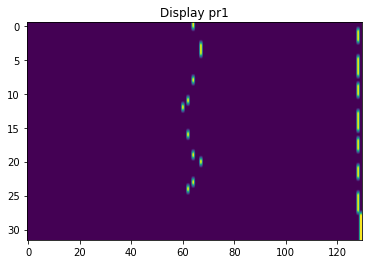

In [15]:
plt.imshow(pr1, aspect='auto')
plt.title('Display pr1')
plt.show()

Melody should be further converted to pytorch tensors, and to cuda/cpu. We should also unsqueeze a batch dimension.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# to pytorch tensor
pr1 = torch.from_numpy(pr1)

# to float32
pr1 = pr1.float()  

# to device (if to cpu, the operation can be omitted.)
pr1 = pr1.to(device)

# unsqueeze the batch dim
pr1 = pr1.unsqueeze(0)


# Concert pr2 similarly
pr2 = torch.from_numpy(pr2).float().to(device).unsqueeze(0)

In [17]:
print(pr1.size(), pr2.size())

torch.Size([1, 32, 130]) torch.Size([1, 32, 130])


Next, define the chords. In EC$^2$-VAE, we use 12-dim chord chroma representation. Chord is a time-series consisting of 32 tokens (16-th notes).

In [18]:
# some useful chords.
amin = [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
gmaj = [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
fmaj = [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
emin = [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
cmaj = [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
cmin = [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]

In [19]:
# c1: Cmaj - - - | Gmaj - - - ||
c1 = np.array([cmaj] * 16 + [gmaj] * 16)

# c2: Amin - Gmaj - | Fmaj - Emin - ||
c2 = np.array([amin] * 8 + [gmaj] * 8 + [fmaj] * 8 + [emin] * 8)

# no chord
c3 = np.zeros((32, 12))

In [20]:
c1 = torch.from_numpy(c1).float().to(device).unsqueeze(0)
c2 = torch.from_numpy(c2).float().to(device).unsqueeze(0)
c3 = torch.from_numpy(c3).float().to(device).unsqueeze(0)

Start to run model. Encode $z_p$ and $z_r$ by calling the encoder.
    

In [21]:
# encode melody 1 and chord C-G
zp1, zr1 = ec2vae_model.encoder(pr1, c1)

# encode melody 2 and "no chord"
zp2, zr2 = ec2vae_model.encoder(pr2, c3)

In [22]:
print(zp1.size(), zr1.size(), zp2.size(), zr2.size())

torch.Size([1, 128]) torch.Size([1, 128]) torch.Size([1, 128]) torch.Size([1, 128])


Let's do the reconstruction of `x_1` and do the what-if generation. We'll use `zp1` and its chord under 16-th note rhythm. We will also try a new chord progression.

In [23]:
pred_recon = ec2vae_model.decoder(zp1, zr1, c1)
pred_new_rhythm = ec2vae_model.decoder(zp1, zr2, c1)
pred_new_chord = ec2vae_model.decoder(zp1, zr1, c2)

The output should be put back to cpu and to numpy.

In [24]:
out_recon = pred_recon.squeeze(0).cpu().numpy()
out_new_rhythm = pred_new_rhythm.squeeze(0).cpu().numpy()
out_new_chord = pred_new_chord.squeeze(0).cpu().numpy()

In [25]:
out_new_rhythm.shape

(32,)

Write the generation to MIDI files. The following function converts note array to a list of pretty_midi Notes.

In [26]:
notes_recon = ec2vae_model.__class__.note_array_to_notes(out_recon, bpm=120, start=0.)
notes_new_rhythm = ec2vae_model.__class__.note_array_to_notes(out_new_rhythm, bpm=120, start=0.)
notes_new_chord = ec2vae_model.__class__.note_array_to_notes(out_new_chord, bpm=120, start=0.)

The following function coverts chord to a list of pretty_midi notes.

In [27]:
notes_c1 = ec2vae_model.__class__.chord_to_notes(c1.squeeze(0).cpu().numpy(), 120, 0)
notes_c2 = ec2vae_model.__class__.chord_to_notes(c2.squeeze(0).cpu().numpy(), 120, 0)

Generate three MIDI files. Note:
1. The original "From the new world" melody should be played with `c1`.
2. The melody transferred to 16-th note rhythm should also be played with `c1`.
3. The melody transferred to a new chord progression should be played with `c2`.

In [28]:
def generate_midi_with_melody_chord(fn, mel_notes, c_notes):
    midi = pm.PrettyMIDI()
    ins1 = pm.Instrument(0)
    ins1.notes = mel_notes
    ins2 = pm.Instrument(0)
    ins2.notes = c_notes
    midi.instruments.append(ins1)
    midi.instruments.append(ins2)
    midi.write(fn)

In [29]:
generate_midi_with_melody_chord('./demo/ec2vae-recon.mid', notes_recon, notes_c1)
generate_midi_with_melody_chord('./demo/ec2vae-new-rhythm.mid', notes_new_rhythm, notes_c1)
generate_midi_with_melody_chord('./demo/ec2vae-new-chord.mid', notes_new_chord, notes_c2)

### Question 2:
1. Write a new melody (maybe with new chord progression). Try transferring the original melody to the new melody contour. During encoding and decode, which chord should we use as condition?
2. Change chord and use same zp and zr. Check the controllability from chord condition. (Our model should not perform very well. Test it on your own!)
3. Consider longer melody, change it per 2-bar.
4. More to explore: sampling from the prior or posterior. (Hint: to get the posterior distribution, re-write the encoder function output.)

## Part two: polyphonic data structure

In Poly-Dis, three types of data structure are used: prmat, chord, and PianoTree representation.

In [30]:
x1 = np.load('./poly_dis/example_data/sample1.npz')

pr_mat1 = x1['pr_mat']
pianotree1 = x1['ptree']
c1 = x1['c']

* prmat

In [31]:
pr_mat1.shape, pr_mat1.max(), pr_mat1.min()

((32, 128), 6.0, 0.0)

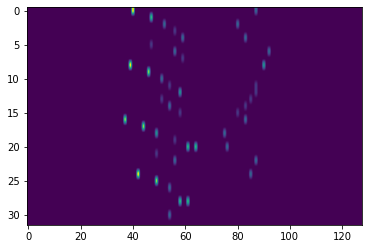

In [32]:
plt.imshow(pr_mat1, aspect='auto')
plt.show()

* chord

In [33]:
c1.shape

(8, 36)

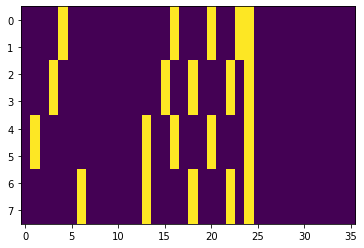

In [34]:
plt.imshow(c1, aspect='auto')
plt.show()

Chord: inner 36-d vecotr:
* 0-11: one-hot root (absolute pitch class)
* 12-23: multi-hot chroma (absolute pitch class)
* 24-35: one-hot bass (relative pitch class)

* PianoTree

In [35]:
pianotree1.shape

(32, 16, 6)

In [36]:
pianotree1[0]

array([[128,   2,   2,   2,   2,   2],
       [ 40,   0,   0,   1,   0,   1],
       [ 87,   0,   0,   0,   0,   1],
       [129,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2]])

In [37]:
pianotree1[1]

array([[128,   2,   2,   2,   2,   2],
       [ 47,   0,   0,   0,   1,   1],
       [129,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2],
       [130,   2,   2,   2,   2,   2]])

Load the second sample in the same fashion.

In [38]:
x2 = np.load('./poly_dis/example_data/sample2.npz')

pr_mat2 = x2['pr_mat']
pianotree2 = x2['ptree']
c2 = x2['c']

## Part three: Poly-Dis

In [39]:
from poly_dis.model import PolyDisVAE

In [40]:
# initialize the model
polydis_model = PolyDisVAE.init_model()

# load model parameters
polydis_param_path = "./poly_dis/model_param/polydis-v1.pt"
polydis_model.load_model(polydis_param_path)

In [41]:
c1 = torch.from_numpy(c1).float().to(device).unsqueeze(0)
c2 = torch.from_numpy(c2).float().to(device).unsqueeze(0)
pr_mat1 = torch.from_numpy(pr_mat1).float().to(device).unsqueeze(0)
pr_mat2 = torch.from_numpy(pr_mat2).float().to(device).unsqueeze(0)

In [42]:
# encode sample 1
z_chd1 = polydis_model.chd_encode(c1)
z_txt1 = polydis_model.txt_encode(pr_mat1)

# encode sample2
z_chd2 = polydis_model.chd_encode(c2)
z_txt2 = polydis_model.txt_encode(pr_mat2)

In [43]:
z_chd1.size(), z_txt1.size(), z_chd2.size(), z_txt2.size()

(torch.Size([1, 256]),
 torch.Size([1, 256]),
 torch.Size([1, 256]),
 torch.Size([1, 256]))

Factor recombination!

In [44]:
out11 = polydis_model.pnotree_decode(z_chd1, z_txt1).squeeze(0)
out12 = polydis_model.pnotree_decode(z_chd1, z_txt2).squeeze(0)
out21 = polydis_model.pnotree_decode(z_chd2, z_txt1).squeeze(0)
out22 = polydis_model.pnotree_decode(z_chd2, z_txt2).squeeze(0)

In [45]:
out11.shape, out12.shape, out21.shape, out22.shape

((32, 15, 6), (32, 15, 6), (32, 15, 6), (32, 15, 6))

**Note 1**: here the `squeeze(0)` is a method for numpy array, not for pytorch tensor!

**Note 2**: The output pianotrees have size (32, 15, 6), not (32, 16, 6), omitting the initial 'sos' token. Check it out!

In [46]:
# convert the output to pretty_midi notes. The converter can handle both (32, 16, 6) and (32, 15, 6) inputs.
notes11 = polydis_model.pnotree_to_notes(out11, bpm=120, start=0.)
notes12 = polydis_model.pnotree_to_notes(out12, bpm=120, start=0.)
notes21 = polydis_model.pnotree_to_notes(out21, bpm=120, start=0.)
notes22 = polydis_model.pnotree_to_notes(out22, bpm=120, start=0.)

In [47]:
# write midi
midi = pm.PrettyMIDI()
ins1 = pm.Instrument(0, name='chd1, txt1')
ins1.notes = notes11

ins2 = pm.Instrument(0, name='chd1, txt2')
ins2.notes = notes12

ins3 = pm.Instrument(0, name='chd2, txt1')
ins3.notes = notes21

ins4 = pm.Instrument(0, name='chd2, txt2')
ins4.notes = notes22

midi.instruments = [ins1, ins2, ins3, ins4]
midi.write('./demo/polyphonic-demo.mid')

### Batching

In pytorch, we usually do not feed in only one data sample. Intead, we feed into the model $n$ samples at a time. We call the $n$ samples a batch, or mini-batch, and $n$ is the batch size. 

Formally, the unsqueezed dimension is the batch size. For example, the input to ec2vae is (1, 32, 130). Actually, it is (bs, 32, 130). bs can be any numbers, usually 32, 64, 128 etc.

Larger batch size is more efficient than writing for loop of batch size = 1.

In [48]:
z_chds = torch.cat([z_chd1, z_chd1, z_chd2, z_chd2], 0)
z_txts = torch.cat([z_txt1, z_txt2, z_txt1, z_txt2], 0)

In [49]:
z_chds.size(), z_txts.size()

(torch.Size([4, 256]), torch.Size([4, 256]))

In [50]:
outs = polydis_model.pnotree_decode(z_chds, z_txts)

In [51]:
outs.shape

(4, 32, 15, 6)

## Appendix: POP909 dataset

Paper: https://program.ismir2020.net/poster_1-04.html
Dataset: https://github.com/music-x-lab/POP909-Dataset